In [1]:
import torch
from torch import nn, optim
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)])
        self.act = act

    def forward(self, x, gamma):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)     # 3 entrées (x,l), 10 sorties
        self.fc2 = nn.Linear(10, 20)    # 10 entrées, 20 sorties
        self.fc3 = nn.Linear(20, 30)    # 20 entrées, 30 sorties
        self.fc4 = nn.Linear(30, 1)     # 30 entrées, 1 sortie
        self.register_parameter('gamma', None)

    def forward(self, x, l):
        self.gamma = torch.ones_like(s) * l
        x = torch.cat((x, self.gamma), dim=1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [66]:
def phi(nn, domain, param):
    print(f"Phi: {param.size()=}")
    return nn(domain, param)


def total_derivative(nn, x, param):
    """ Compute the left-hand side of the Poisson equation in the case of a Dehnen potential:
        d/dr (r^2 dphi/dr) = 2r^(2-\gamma)/(r+1)^{4-\gamma}
    """
    print(f"total_derivative 1 {param.size()=}")
    phi_val = phi(nn, x, param)
    dphi_val = torch.autograd.grad(phi_val, x,
                                   grad_outputs=torch.ones_like(x),
                                   create_graph=True,
                                   retain_graph=True, )[0]
    print(f"total_derivative 2 {param.size()=}")
    f = dphi_val * x ** 2
    df = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True,)[0]
    print(f"total_derivative 3{param.size()=}")
    return df

In [68]:
def loss_function(neural_net, domain, gamma, boundaries=(0., 0.)):
    print("loss_function")
    print(f"{gamma.size()=}")
    if gamma[0] >= 3:
        raise ValueError("Parameter gamma cannot be greater than 3 (not included)")
    x0, f0 = boundaries
    power_gamma = int(gamma[0])
    power1 = 2 - power_gamma
    power2 = 4 - power_gamma
    interior_loss = total_derivative(neural_net, domain, gamma) - (2 * domain**power1) / (domain + 1) ** power2
    # interior_loss /= -(2 * domain ** power1) / (domain + 1) ** power2 # normalize for convergence
    # interior_loss = 2 * total_derivative(neural_net, domain) * ((domain + 1) ** 3)/domain - 1
    # Boundary contribution
    boundary = torch.Tensor([x0])
    boundary.requires_grad = True
    boundary_loss = phi(neural_net, boundary, gamma[0]) - f0
    print("loss_function out")
    print(f"{gamma.size()=}")
    return interior_loss.pow(2).mean() + boundary_loss[0] ** 2

In [54]:
class TrainingPhase:
    def __init__(self, neural_net, domain, n_epochs, optimizer, _loss_function, boundaries, params):
        self.neural_net = neural_net
        self.domain = domain
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.loss_function = _loss_function
        self.boundaries = boundaries
        self.x0, self.f0 = boundaries
        self.gamma = params

    def train_model(self):
        opt = self.optimizer(self.neural_net.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                           mode='min',
                                                           factor=0.5,
                                                           patience=1000,
                                                           threshold=0.0001,
                                                           verbose=True)
        loss = self.loss_function

        losses = []
        epochs = []
        for epoch in trange(self.n_epochs, desc="Epoch"):

            opt.zero_grad()
            loss_value = loss(self.neural_net, self.domain, self.gamma, self.boundaries)
            loss_value.backward()
            opt.step()

            losses.append(loss_value.item())
            # if epoch % 100 == 0:
                # print("Époque : ", epoch, "Loss:", loss_value.item())
        return self.neural_net, np.array(epochs), np.array(losses)

    def save_model(self, filename):
        torch.save(self.neural_net, filename)

In [ ]:
def analytic_prediction(r, _a, _gamma):
    """ Value of the gravitational potential 
        in the case of an Dehnen profile 
    """
    if _gamma == 2:
        return np.log(r/(r + _a))
    else:
        power1 = 2 - _gamma
        return -1/power1 * (1 - (r/(r + _a)) ** power1)

# PARAMETERS
n_epochs = 50_000
a = 1.0


s = torch.linspace(0.01, 10, 1000, requires_grad=True)
s = s.reshape(-1, 1)
l = 1
pinn = Net()

print("Training Neural Network :", pinn)

# Domain
s = torch.linspace(0.01, 10, 1000, requires_grad=True)
s = s.reshape(-1, 1)

# Initial conditions
x0 = s.detach().numpy()[0][0] * a
f0 = analytic_prediction(x0, a, gamma)

training = TrainingPhase(neural_net=pinn, domain=s, n_epochs=n_epochs, 
                         optimizer=optim.Adam,_loss_function=loss_function, boundaries=(x0, f0), params=l)

net, epochs, losses = training.train_model()
training.save_model(f"resultats/Hernquist_{n_epochs}.pt")


s_plot = torch.linspace(0.1, 10, 1000, requires_grad=False) # Testing domain ?
y_true = analytic_prediction(s_plot.detach().numpy() * a, a, gamma)
y_pred_plot = phi(net, s_plot.reshape(-1, 1), l).ravel()
y_pred_train = phi(net, s, l)

Conditions aux bords:

Oui, pour l'intervalle [0, 100], les conditions aux bords sont :

$$\phi(0) = -\frac{M}{a^{2-\gamma}}\frac{\gamma-2}{2-\gamma}$$

et

$$\phi(100) = -\frac{M}{(100+a)^{2-\gamma}}\frac{\gamma-2}{2-\gamma}$$

où $M$ est la masse totale de la distribution de masse et $\gamma$ est le paramètre de Dehnen.

En utilisant la formule du potentiel gravitationnel lié à la distribution de masse de Dehnen, on peut calculer les valeurs numériques de ces conditions aux bords pour l'intervalle [0, 100]:

$$\phi(0) = -\frac{M}{a^{2-\gamma}}\frac{\gamma-2}{2-\gamma} = -\frac{M}{a} \frac{\gamma-2}{2-\gamma}$$

et

$$\phi(100) = -\frac{M}{(100+a)^{2-\gamma}}\frac{\gamma-2}{2-\gamma}$$

Par exemple, pour $M=1$, $a=1$ et $\gamma=1.5$, on a :

$$\phi(0) = -\frac{1}{1} \frac{1.5-2}{2-1.5} = 2$$

et

$$\phi(100) = -\frac{1}{101^{0.5}}\frac{0.5}{0.5} \approx -0.03162$$

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def dehnen(radius, scale_factor, gamma):
    """ Value of the gravitational potential
        in the case of a Dehnen profile
    """
    if gamma == 2:
        return np.log(radius / (radius + scale_factor))
    power1 = 2 - gamma
    return -1 / power1 * (1 - (radius / (radius + scale_factor)) ** power1)

In [9]:
dehnen(100, 1, 1.5)

-0.009925619580021694

In [7]:
def min_max_tensor(x, intervalle, min_x=None, max_x=None):
    _a, b = intervalle
    if min_x is None:
        min_x = x.min()
    if max_x is None:
        max_x = x.max()
    return (((x - min_x) / (max_x - min_x)) * (b - _a)) + _a

In [50]:
domaine = np.linspace(0.01, 100, 1000)
phi = dehnen(domaine, 1, 1.5)

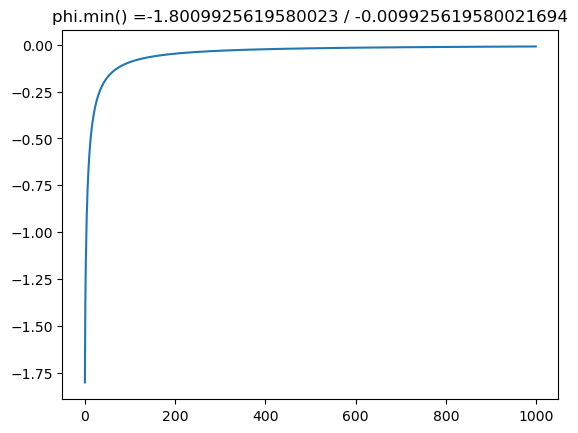

In [51]:
plt.figure()
plt.title(f"{phi.min() =} / {phi.max()}")
plt.plot(phi);

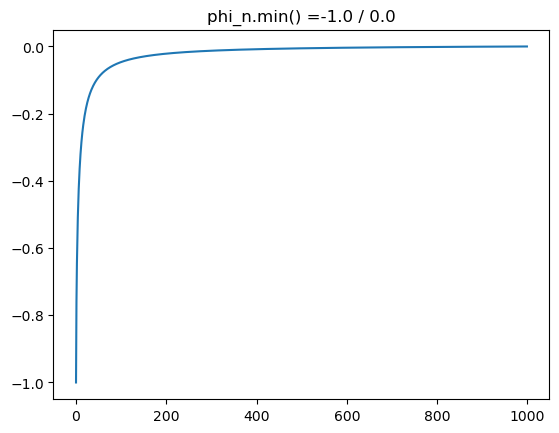

In [52]:
phi_n = min_max_tensor(phi, (-1, 0))
plt.figure()
plt.title(f"{phi_n.min() =} / {phi_n.max()}")
plt.plot(phi_n);

In [63]:
def plot_phi(gammas):
    plt.figure()
    for gamma in gammas:
        phi = dehnen(domaine, 1, gamma)
        print(gamma)
        if gamma == 2:
            continue
        phi_n = min_max_tensor(phi, (-1, 0))
        plt.plot(phi_n, label=str(gamma))
    plt.legend()
    plt.show()

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004


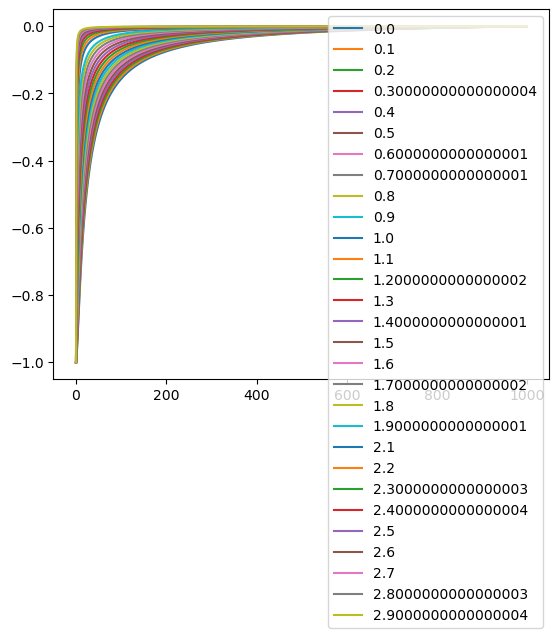

In [64]:
plot_phi(np.arange(0, 3, 0.1))

In [30]:
np.arange(0, 2.99, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

In [45]:
domaine + 1

array([  1.        ,   1.1001001 ,   1.2002002 ,   1.3003003 ,
         1.4004004 ,   1.5005005 ,   1.6006006 ,   1.7007007 ,
         1.8008008 ,   1.9009009 ,   2.001001  ,   2.1011011 ,
         2.2012012 ,   2.3013013 ,   2.4014014 ,   2.5015015 ,
         2.6016016 ,   2.7017017 ,   2.8018018 ,   2.9019019 ,
         3.002002  ,   3.1021021 ,   3.2022022 ,   3.3023023 ,
         3.4024024 ,   3.5025025 ,   3.6026026 ,   3.7027027 ,
         3.8028028 ,   3.9029029 ,   4.003003  ,   4.1031031 ,
         4.2032032 ,   4.3033033 ,   4.4034034 ,   4.5035035 ,
         4.6036036 ,   4.7037037 ,   4.8038038 ,   4.9039039 ,
         5.004004  ,   5.1041041 ,   5.2042042 ,   5.3043043 ,
         5.4044044 ,   5.5045045 ,   5.6046046 ,   5.7047047 ,
         5.8048048 ,   5.9049049 ,   6.00500501,   6.10510511,
         6.20520521,   6.30530531,   6.40540541,   6.50550551,
         6.60560561,   6.70570571,   6.80580581,   6.90590591,
         7.00600601,   7.10610611,   7.20620621,   7.30